<h1 style='text-align:center; color:blue;'> Healthcare Premium Prediction Model</h1>

## Import Libraries

In [360]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, ridge_regression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

## Data Loading

In [361]:
df=pd.read_excel("premium_rest_vishant.xlsx")
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


### Check shape of data

In [362]:
df.shape

(29904, 13)

### Convert columns into lower case

In [363]:
df.columns=df.columns.str.replace("_", " ").str.lower()
df.columns=df.columns.str.replace(" ", "_").str.lower()

## Exploratory Data-analysis and data cleaning

### Handle Missing value

In [364]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [365]:
df.dropna(inplace=True)

In [366]:
df.shape

(29886, 13)

In [367]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle Duplicate values

In [368]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [369]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


#### Data Cleaning: number of dependants

In [370]:
df[df.number_of_dependants<0].shape

(50, 13)

In [371]:
df['number_of_dependants']=abs(df['number_of_dependants'])
df[df.number_of_dependants<0].shape

(0, 13)

In [372]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.385933,23.364184,20892.303821
std,13.412657,1.421137,24.740339,6936.813440
min,26.000000,0.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


## 1. Numeric Columns

### Univariate Analysis:Numeric Columns

#### Box plot for numeric columns

In [373]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [374]:
numeric_columns=df.select_dtypes(include='number').columns    ## or df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

In [375]:
num_rows=int(len(numeric_columns)/2)
num_rows

2

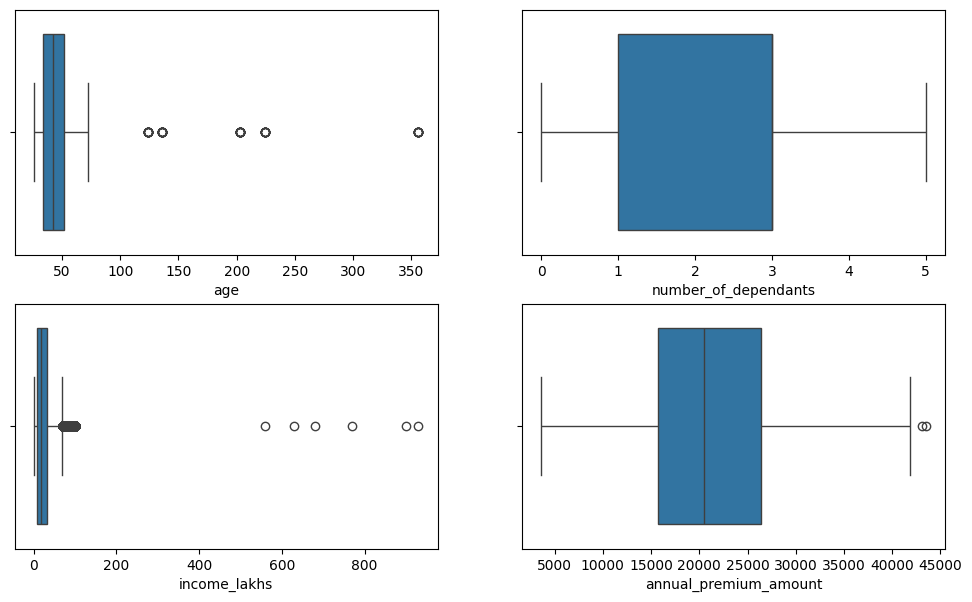

In [376]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axis[i])
plt.show()

### Outlier treatment: Age column

In [377]:
df.age.describe()

count    29886.000000
mean        43.396105
std         13.412657
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max        356.000000
Name: age, dtype: float64

In [378]:
df[df['age']>100].shape

(58, 13)

In [379]:
def limits(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound, upper_bound

limits('age')

(np.float64(7.0), np.float64(79.0))

In [380]:
df['age'].quantile(0.25)

np.float64(34.0)

In [381]:
df['age'].quantile(0.75)

np.float64(52.0)

In [382]:
df['age'].quantile(0.99)

np.float64(70.0)

In [383]:
df[df['age']>100].age.shape

(58,)

In [384]:
df1=df[df['age']<100].copy()
df1

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29899,60,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,25L - 40L,26,High blood pressure,Gold,26370
29900,40,Female,Southeast,Unmarried,0,Overweight,Regular,Salaried,10L - 25L,16,Diabetes & Thyroid,Gold,29496
29901,37,Female,Northwest,Unmarried,0,Obesity,No Smoking,Salaried,<10L,4,No Disease,Bronze,10957
29902,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076


In [385]:
df1.age.describe()

count    29828.000000
mean        43.095380
std         11.041991
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max         72.000000
Name: age, dtype: float64

### Outlier treatment :Income columns

In [386]:
def get_iqr_limits(col):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound, upper_bound

get_iqr_limits('income_lakhs')

(np.float64(-30.5), np.float64(69.5))

In [387]:
df1[df1['income_lakhs']>67].shape

(2224, 13)

In [388]:
income_thershold=df1['income_lakhs'].quantile(0.999)
income_thershold

np.float64(100.0)

In [389]:
df2=df1[df1['income_lakhs']<=income_thershold].copy()
df2.shape

(29822, 13)

In [390]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


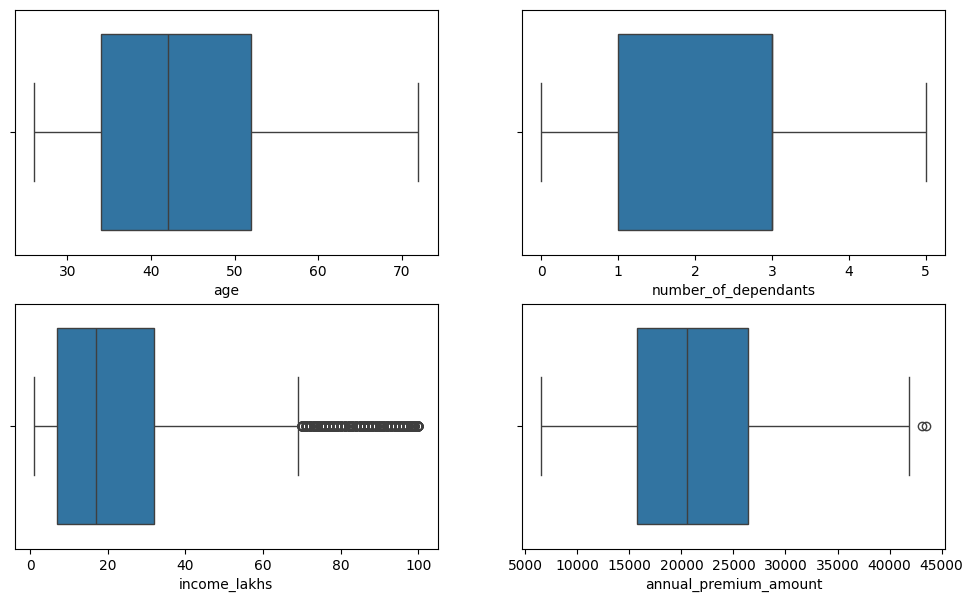

In [391]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df2[col], ax=axis[i])
plt.show()

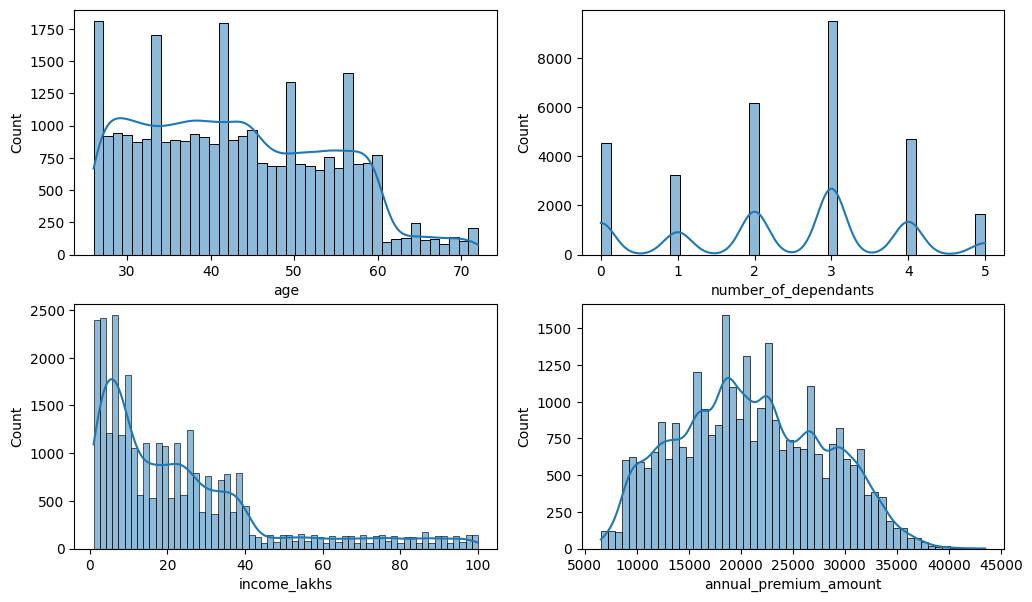

In [392]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.histplot(x=df2[col], ax=axis[i], kde=True)
plt.show()

In [393]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


### Bivariate Analysis:Numeric Columns

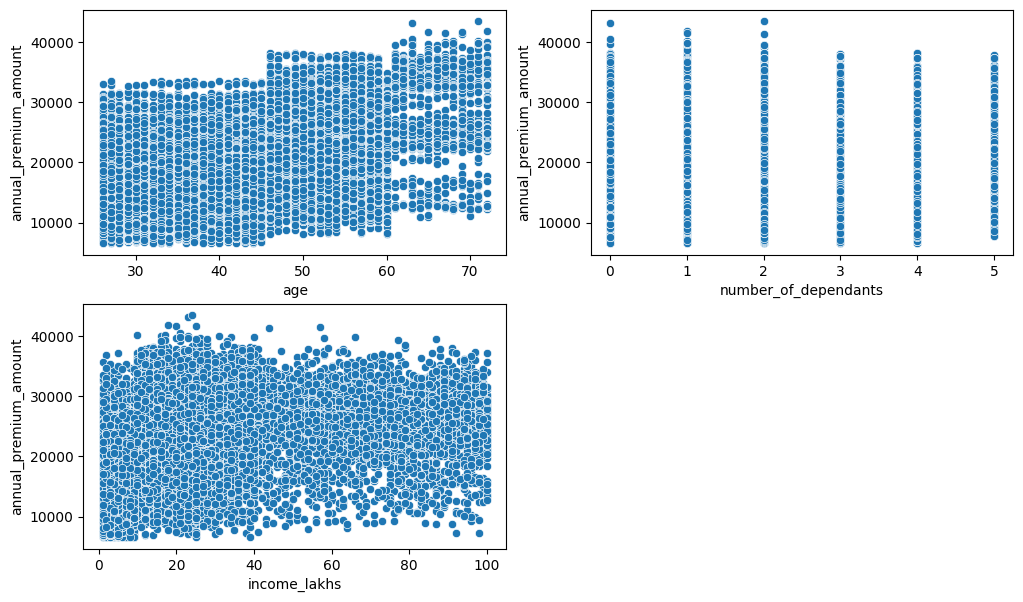

In [394]:
figure, axis=plt.subplots(num_rows, 2, figsize=(12,3.5*num_rows))
axis=axis.flatten()
for i, col in enumerate(numeric_columns):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=axis[i])


for i in range(len(numeric_columns)-1,len(numeric_columns)):
    figure.delaxes(axis[i])


plt.show()

## 2. Categorical Columns

In [395]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29822 entries, 0 to 29903
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    29822 non-null  int64 
 1   gender                 29822 non-null  object
 2   region                 29822 non-null  object
 3   marital_status         29822 non-null  object
 4   number_of_dependants   29822 non-null  int64 
 5   bmi_category           29822 non-null  object
 6   smoking_status         29822 non-null  object
 7   employment_status      29822 non-null  object
 8   income_level           29822 non-null  object
 9   income_lakhs           29822 non-null  int64 
 10  medical_history        29822 non-null  object
 11  insurance_plan         29822 non-null  object
 12  annual_premium_amount  29822 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 3.2+ MB


In [396]:
categorical_cols=df2.select_dtypes(include=['object']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [397]:
for col in categorical_cols:
    print(f" {col}--->{df2[col].unique()}")
    print("-"*50)

 gender--->['Male' 'Female']
--------------------------------------------------
 region--->['Northwest' 'Southeast' 'Northeast' 'Southwest']
--------------------------------------------------
 marital_status--->['Unmarried' 'Married']
--------------------------------------------------
 bmi_category--->['Normal' 'Obesity' 'Overweight' 'Underweight']
--------------------------------------------------
 smoking_status--->['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
--------------------------------------------------
 employment_status--->['Salaried' 'Self-Employed' 'Freelancer']
--------------------------------------------------
 income_level--->['<10L' '10L - 25L' '> 40L' '25L - 40L']
--------------------------------------------------
 medical_history--->['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
------

In [398]:
df2['smoking_status']=df2['smoking_status'].replace({'Smoking=0':'No Smoking',
                                                     'Does Not Smoke':'No Smoking',
                                                     'Not Smoking':'No Smoking'})

In [399]:
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis

In [400]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [401]:
pct_count=df2.gender.value_counts(normalize=True)*100
pct_count

gender
Male      54.912481
Female    45.087519
Name: proportion, dtype: float64

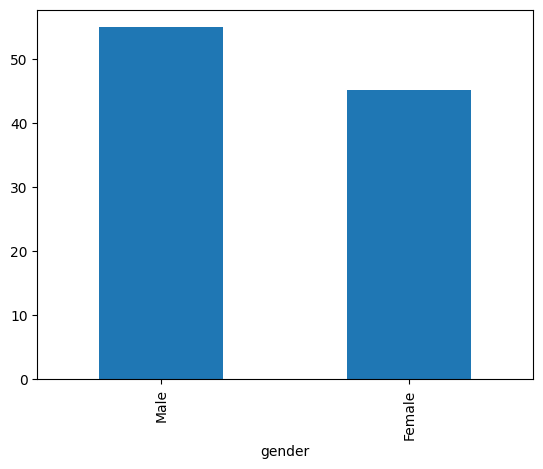

In [402]:
pct_count.plot(kind='bar')
plt.show()

In [403]:
num_rows_1=int(len(categorical_cols)/3)
num_rows_1

3

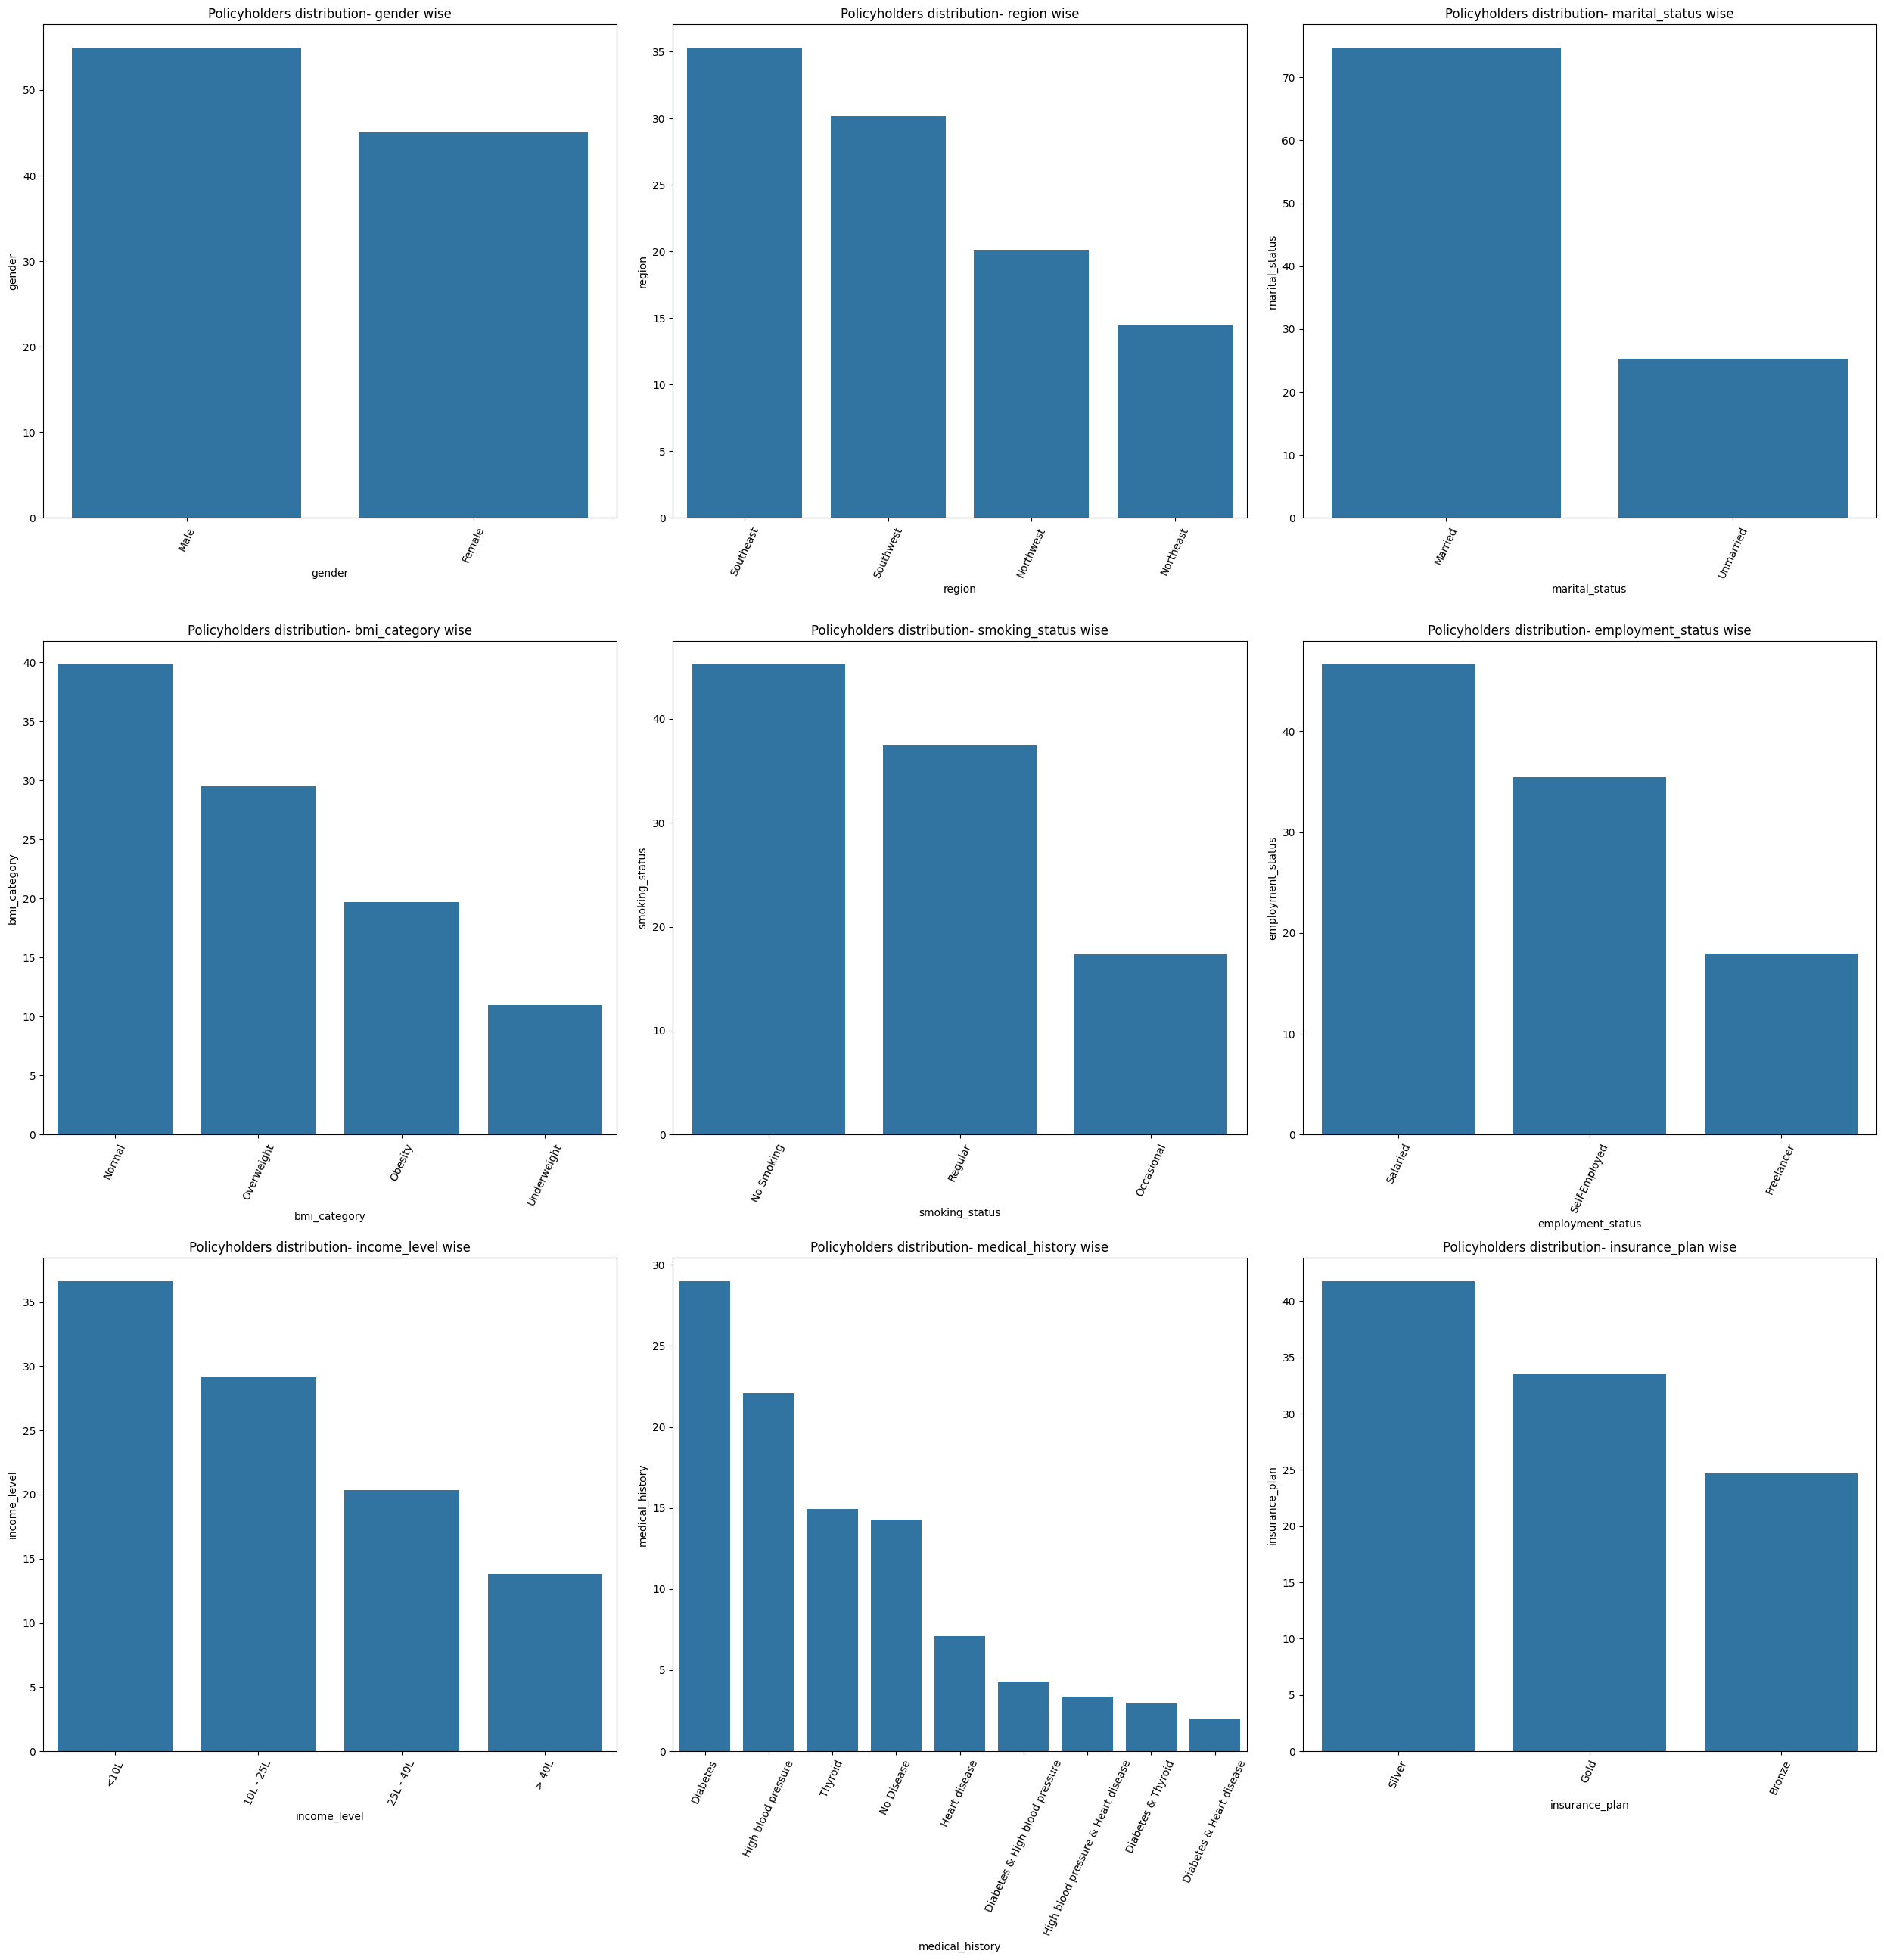

In [404]:
figure, axis=plt.subplots(num_rows_1, 3, figsize=(25, num_rows*13))
axis=axis.flatten()

for i, col in enumerate(categorical_cols):
    pct_count=df2[col].value_counts(normalize=True)*100
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=axis[i])
    axis[i].set_title(f"Policyholders distribution- {col} wise")
    axis[i].set_ylabel(col)
    axis[i].tick_params(axis='x', rotation=65)
plt.tight_layout()
plt.show()

###  Bivariate Analysis

In [405]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [406]:
df3=df2.groupby(['income_level', 'insurance_plan'])[['insurance_plan']].count()
df3

insurance_plan
income_level insurance_plan                
10L - 25L    Bronze                     799
             Gold                      3554
             Silver                    4354
25L - 40L    Bronze                     301
             Gold                      2631
             Silver                    3142
<10L         Bronze                    6054
             Gold                       527
             Silver                    4341
> 40L        Bronze                     214
             Gold                      3287
             Silver                     618

<Axes: xlabel='income_level', ylabel='insurance_plan'>

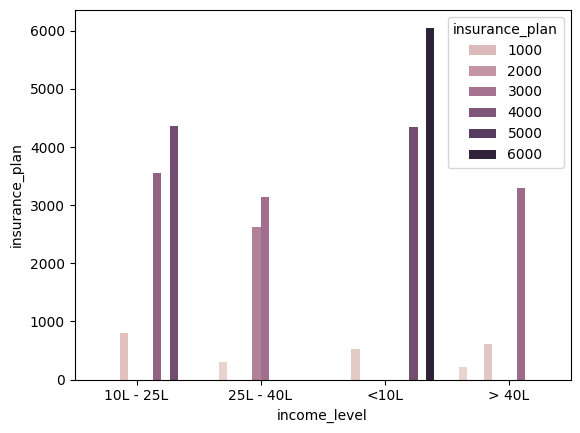

In [407]:
sns.barplot(data=df3, x='income_level', y='insurance_plan', hue='insurance_plan')

In [408]:
cross_tab=pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


<Axes: xlabel='income_level'>

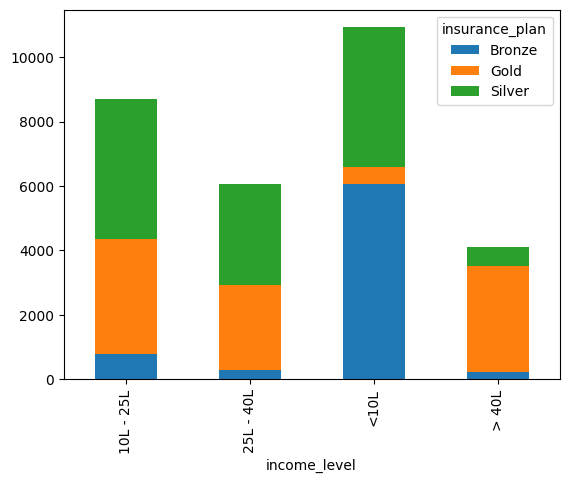

In [409]:
cross_tab.plot(kind='bar', stacked=True)

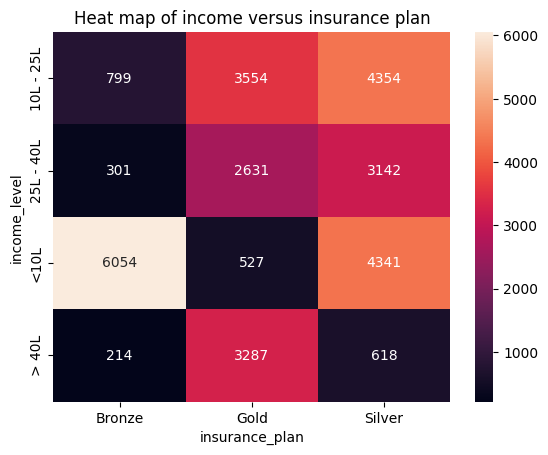

In [410]:
sns.heatmap(data=cross_tab, annot=True, fmt='d')
plt.title("Heat map of income versus insurance plan")
plt.show()

##  Feature Engineering

###  Calculate Risk Score

In [411]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [412]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [413]:
#define risk score for each condition
risk_score={"diabetes":6, "heart disease":8, "high blood pressure":6, "thyroid" :5, "no Disease":0, 'none':0}
df2[["disease_1","disease_2"]]=df2['medical_history'].str.split(" & ", expand=True).apply(lambda x:x.str.lower())
df2['disease_1']=df2['disease_1'].fillna('none')
df2['disease_2']=df2['disease_2'].fillna('none')

df2['total_risk_score']=0
for disease in ['disease_1', 'disease_2']:
    df2[disease]=df2[disease].map(risk_score)
    df2['total_risk_score']+=df2[disease]

In [414]:
df2['total_risk_score']=df2['total_risk_score'].fillna(0)

In [415]:
#normalization of risk score

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df2['normalized_risk_score']=scaler.fit_transform(df2[['total_risk_score']])
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,6.0,0,6.0,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,6.0,0,6.0,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,6.0,0,6.0,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,NaN,0,0.0,0.000000


### Encode Text column

In [416]:
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':1, 'Silver':2,'Gold':3})

In [417]:
df2.insurance_plan.unique()

array([1, 2, 3])

In [418]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [419]:
df2['income_level']=df2['income_level'].map({'<10L':1, '10L - 25L':2, '> 40L':3, '25L - 40L':4})

In [420]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'disease_1', 'disease_2', 'total_risk_score',
       'normalized_risk_score'],
      dtype='object')

In [421]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']

df3=pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

In [422]:
df3.head(4)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,6.0,0,6.0,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,6.0,0,6.0,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,6.0,0,6.0,...,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,No Disease,3,20303,NaN,0,0.0,...,1,0,0,0,0,0,0,0,1,0


In [423]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29822 entries, 0 to 29903
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              29822 non-null  int64  
 1   number_of_dependants             29822 non-null  int64  
 2   income_level                     29822 non-null  int64  
 3   income_lakhs                     29822 non-null  int64  
 4   medical_history                  29822 non-null  object 
 5   insurance_plan                   29822 non-null  int64  
 6   annual_premium_amount            29822 non-null  int64  
 7   disease_1                        25557 non-null  float64
 8   disease_2                        29822 non-null  int64  
 9   total_risk_score                 29822 non-null  float64
 10  normalized_risk_score            29822 non-null  float64
 11  gender_Male                      29822 non-null  int64  
 12  region_Northwest       

### Feature Selection

In [424]:
dropped_columns=['medical_history', 'total_risk_score', 'disease_1', 'disease_2']
df4=df3.drop(dropped_columns, axis=1)

In [425]:
df4

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,3,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29899,60,3,4,26,3,26370,0.428571,0,1,0,0,0,0,0,0,0,0,0,1
29900,40,0,2,16,3,29496,0.785714,0,0,1,0,1,0,1,0,0,1,1,0
29901,37,0,1,4,1,10957,0.000000,0,1,0,0,1,1,0,0,0,0,1,0
29902,47,2,3,82,3,27076,0.357143,0,0,1,0,0,0,0,0,0,0,1,0


### Calculate VIF for multicolinearity

In [426]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

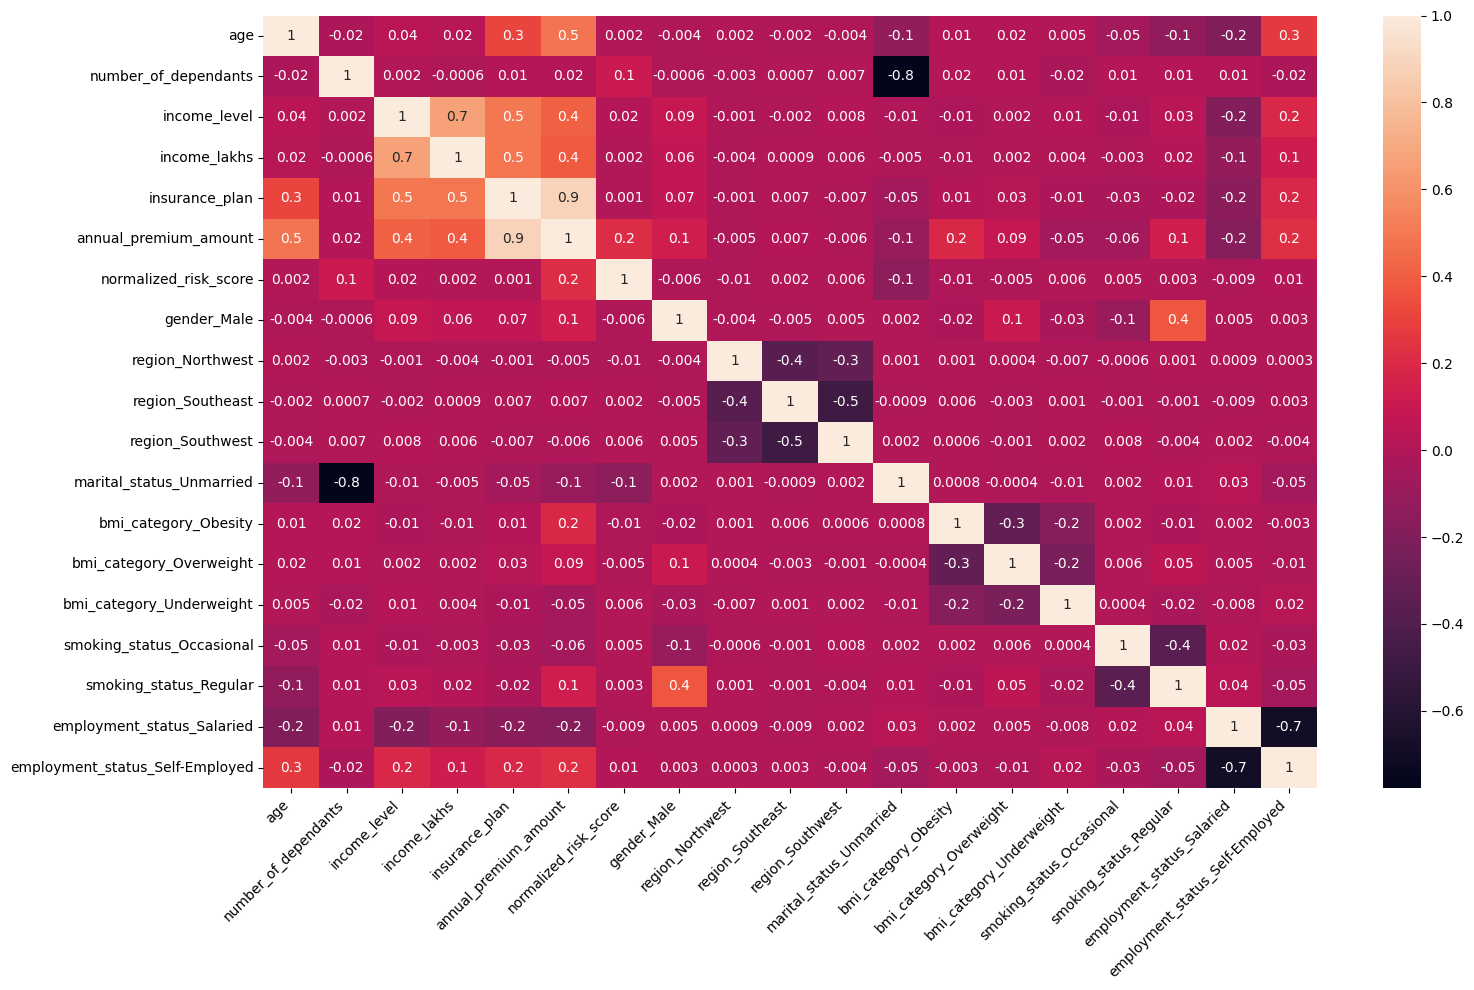

In [427]:
cm=df4.corr()

plt.figure(figsize=(16,10))
sns.heatmap(cm, annot=True, fmt='0.1g')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [428]:
X=df4.drop('annual_premium_amount', axis=1)
y=df4['annual_premium_amount']
scaler=MinMaxScaler()
cols=['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
X[cols]=scaler.fit_transform(X[cols])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.393077,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.378150,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [429]:
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data.values,i) for i in range (data.shape[1])]
    return vif_df

In [430]:
calculate_vif(X)

,variable,VIF
0,age,3.882319
1,number_of_dependants,6.292550
2,income_level,4.104266
3,income_lakhs,3.797992
4,insurance_plan,4.931114
5,normalized_risk_score,3.815157
6,gender_Male,2.599039
7,region_Northwest,2.124859
8,region_Southeast,2.981854
9,region_Southwest,2.711344


In [431]:
calculate_vif(X.drop('income_level', axis=1))

,variable,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [432]:
X_reduced=X.drop('income_level', axis=1)

##  Model Training

In [433]:
X_train, X_test, y_train, y_test=train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#print shape of X_reduced, X_train, X_test, y_train, y_test features
print(f"X_reduced shape: {X_reduced.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_reduced shape: (29822, 17)
X_train shape: (20875, 17)
X_test shape : (8947, 17)
y_train shape: (20875,)
y_test shape: (8947,)


### Linear Regression model

In [434]:
model_lr=LinearRegression()
#training a model
model_lr.fit(X_train, y_train)

#predicting model r2 score
test_score=model_lr.score(X_test, y_test)
train_score=model_lr.score(X_train, y_train)
test_score, train_score

(0.9546117251336064, 0.9530815646744318)

In [435]:
#prediction values
y_pred=model_lr.predict(X_test)

#RMSE 
mse=mean_squared_error(y_test, y_pred)
rmse=np.sqrt(mse)
print(f"Linear Regression MSE {mse}, RMSE: {rmse}")

Linear Regression MSE 2183801.8818571903, RMSE: 1477.7692248308565


In [436]:
len(model_lr.coef_)

17

In [437]:
len(X_train.columns)

17

In [438]:
feature_importance=model_lr.coef_
feature_importance

array([ 7014.39496675, -1247.79337884,  -748.5047392 , 14840.07632438,
        6029.14742861,    42.76580366,   -76.16565671,   -25.08331687,
         -53.33779201,  -702.17193058,  3930.46262822,  1999.07429281,
         598.45525871,   855.18031748,  2816.79153464,   -73.4601338 ,
         248.75420828])

In [439]:
coef_df=pd.DataFrame(feature_importance,index=X_train.columns, columns=['Coefficient'])
coef_df=coef_df.sort_values(by='Coefficient')

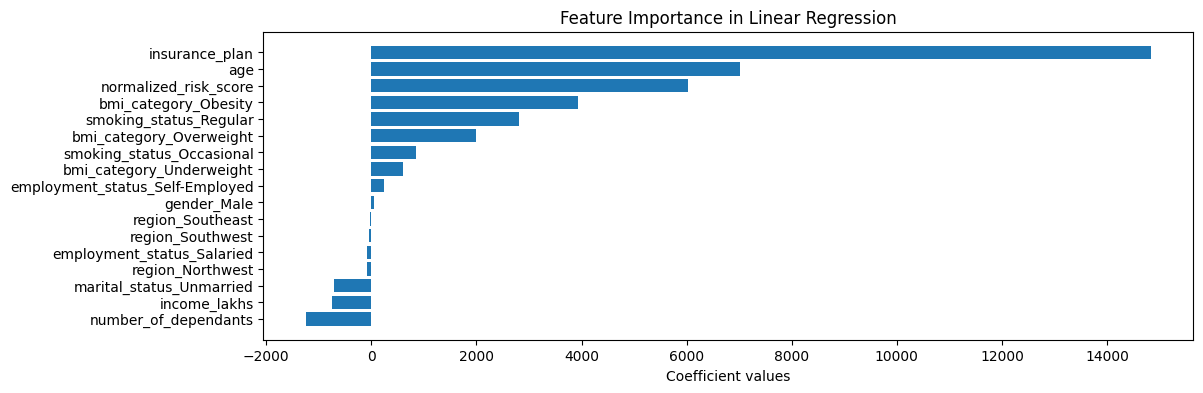

In [440]:
plt.figure(figsize=(12,4))
plt.barh(data=coef_df, y=coef_df.index,width=coef_df.Coefficient)
plt.xlabel('Coefficient values')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression model

In [441]:
model_rg=Ridge(alpha=1)
model_rg.fit(X_train, y_train)

Ridge(alpha=1)

In [442]:
test_score_rg=model_rg.score(X_test, y_test)
train_score_rg=model_rg.score(X_train, y_train)
train_score, test_score

(0.9530815646744318, 0.9546117251336064)

In [443]:
y_pred_rg=model_rg.predict(X_test)
MSE_rg=mean_squared_error(y_test,y_pred_rg)
RMSE_rg=np.sqrt(MSE_rg)
R2_score_rg=r2_score(y_test,y_pred_rg)

print(f"RMSE of Ridge regression model {RMSE_rg}, R2 Score of Ridge regression {R2_score_rg}")

RMSE of Ridge regression model 1477.759593251274, R2 Score of Ridge regression 0.954612316781273


### XGBoost

In [444]:
model_xgb=XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [445]:
y_pred_xgb=model_xgb.predict(X_test)

In [446]:
test_score_xgb=model_xgb.score(X_test, y_test)
train_score_xgb=model_xgb.score(X_train, y_train)
train_score, test_score

(0.9530815646744318, 0.9546117251336064)

In [447]:
y_pred_xgb=model_xgb.predict(X_test)
MSE_xgb=mean_squared_error(y_test,y_pred_xgb)
RMSE_xgb=np.sqrt(MSE_xgb)
R2_score_xgb=r2_score(y_test,y_pred_xgb)

print(f"RMSE of Ridge regression model {RMSE_xgb}, R2 Score of Ridge regression {R2_score_xgb}")

RMSE of Ridge regression model 309.6301977763151, R2 Score of Ridge regression 0.9980074167251587


#### Randomized SearchCV

In [448]:
model_xgb=XGBRegressor()
param_grid={
            'n_estimators':[20,40,50],
            'learning_rate':[0.01,0.1,0.2],
            'max_depth':[3,4,5] }
random_search=RandomizedSearchCV(model_xgb, param_grid,n_iter=10, cv=3, scoring='r2',random_state=42, n_jobs=-1)
random_search

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [449]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [450]:
random_search.best_score_

np.float64(0.9970021843910217)

In [451]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [452]:
best_model=random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [453]:
feature_importance=best_model.feature_importances_

#create DataFrame for Data Handling
coef_df=pd.DataFrame(feature_importance,index=X_train.columns, columns=['Coefficient'])
coef_df=coef_df.sort_values(by='Coefficient')

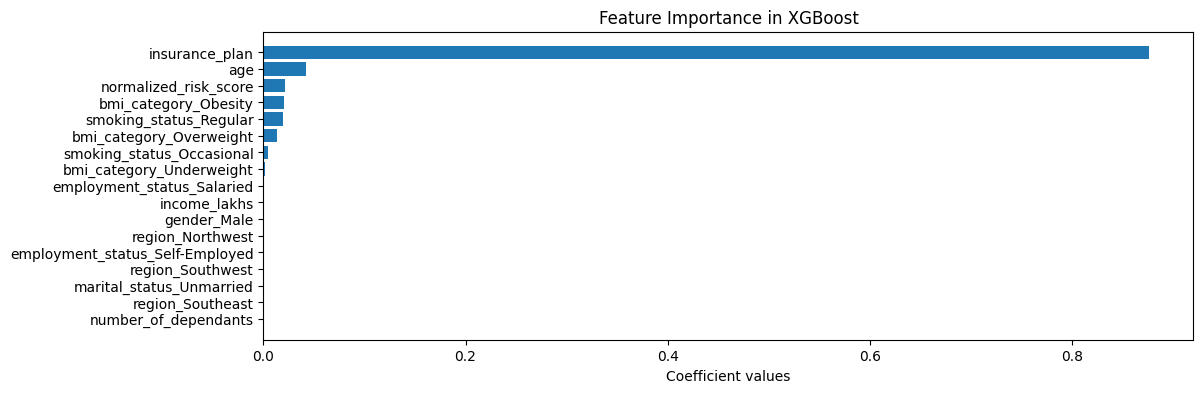

In [454]:
plt.figure(figsize=(12,4))
plt.barh(data=coef_df, y=coef_df.index,width=coef_df.Coefficient)
plt.xlabel('Coefficient values')
plt.title('Feature Importance in XGBoost')
plt.show()

Feature importance in XGBoost may not be as straightforward to interpret as feature importance in Linear Regression, Since XGBoost is a tree based model.

##  Error Analysis

In [455]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=residuals*100/y_test
result_df=pd.DataFrame({'Truth':y_test, 'Prediction':y_pred, 'diff':residuals, 'diff_pct':residuals_pct})
result_df

,Truth,Prediction,diff,diff_pct
5495,30838,31168.615234,330.615234,1.072103
582,26306,26138.769531,-167.230469,-0.635712
281,17983,17611.283203,-371.716797,-2.067046
15443,19345,18925.240234,-419.759766,-2.169862
24281,33317,33256.734375,-60.265625,-0.180886
...,...,...,...,...
12305,33760,33256.734375,-503.265625,-1.490716
2117,24710,24905.050781,195.050781,0.789360
23521,31709,31269.921875,-439.078125,-1.384711
29683,10787,10488.108398,-298.891602,-2.770850


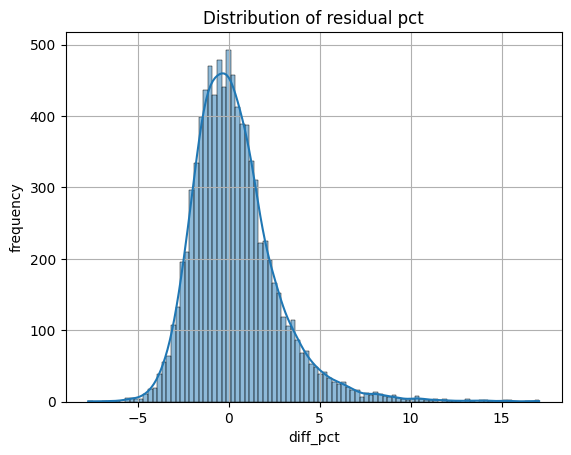

In [456]:
sns.histplot(result_df['diff_pct'], kde=True)
plt.grid()
plt.title('Distribution of residual pct')
plt.ylabel('frequency')
plt.show()

In [457]:
extreme_error_thresh=10
extreme_result_df=result_df[np.abs(result_df['diff_pct'])>=extreme_error_thresh]
extreme_result_df

,Truth,Prediction,diff,diff_pct
17866,6909,7653.522949,744.522949,10.776132
252,7633,8430.017578,797.017578,10.441734
11864,6924,7653.522949,729.522949,10.536149
16263,8206,9144.170898,938.170898,11.432743
28595,7580,8430.017578,850.017578,11.213952
14286,6845,7653.522949,808.522949,11.811877
8506,6640,7653.522949,1013.522949,15.263900
6137,6538,7653.522949,1115.522949,17.062144
11779,6873,7653.522949,780.522949,11.356365
508,8579,9442.622070,863.622070,10.066699


In [458]:
X_test.shape, y_test.shape, result_df.shape

((8947, 17), (8947,), (8947, 4))

In [459]:
(extreme_result_df.shape[0]/X_test.shape[0])*100

0.5029618866659216

In [471]:
extreme_result_df.shape

(45, 5)

0.5% of data are having error greater than 10% which we around 30 % of customers are overcharged or undercharged by 10% or more.

In [460]:
extreme_error_thresh=50
extreme_result_df_50=result_df[np.abs(result_df['diff_pct'])>=extreme_error_thresh]
extreme_result_df_50

,Truth,Prediction,diff,diff_pct


In [461]:
(extreme_result_df_50.shape[0]/X_test.shape[0])*100

0.0

No data are having error greater than 50% which we around 3.5% of customers are overcharged or undercharged by 50% or more.

In [462]:
extreme_errors=X_test.loc[extreme_result_df.index]
extreme_errors.sample(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12841,0.173913,0.6,0.040404,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0
17866,0.152174,0.6,0.060606,0.0,0.000000,0,0,0,0,0,0,0,0,0,0,1,0
15581,0.391304,0.6,0.020202,0.0,0.857143,1,0,0,0,0,0,0,0,0,0,1,0
7509,0.065217,0.0,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,0,1,0
11189,0.173913,0.0,0.060606,0.0,0.428571,0,0,1,0,1,0,0,0,0,0,0,1


In [463]:
df4.loc[extreme_result_df.index]


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
17866,33,3,1,7,1,6909,0.000000,0,0,0,0,0,0,0,0,0,0,1,0
252,29,3,1,3,1,7633,0.000000,1,0,1,0,0,0,0,0,1,0,0,0
11864,28,1,1,3,1,6924,0.000000,1,0,0,1,1,0,0,0,0,0,1,0
16263,57,3,4,39,1,8206,0.000000,1,1,0,0,0,0,0,0,0,0,0,0
28595,36,0,4,31,1,7580,0.000000,0,0,0,1,1,0,0,0,1,0,0,1
14286,27,3,1,6,1,6845,0.000000,1,1,0,0,1,0,0,0,0,0,1,0
8506,44,3,1,7,1,6640,0.000000,1,0,0,1,0,0,0,0,0,0,0,0
6137,43,1,1,5,1,6538,0.000000,1,0,0,1,1,0,0,0,0,0,0,0
11779,26,1,1,7,1,6873,0.000000,0,0,1,0,1,0,0,0,0,0,1,0
508,41,1,1,6,1,8579,0.428571,0,1,0,0,1,0,0,0,0,0,1,0


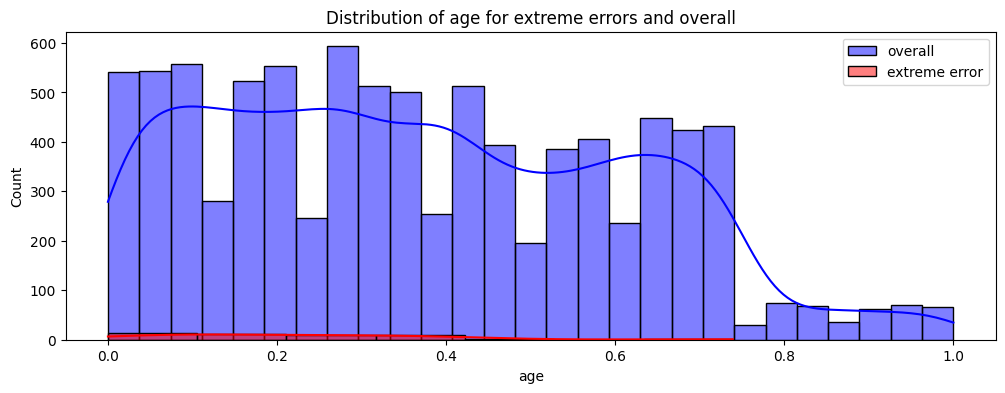

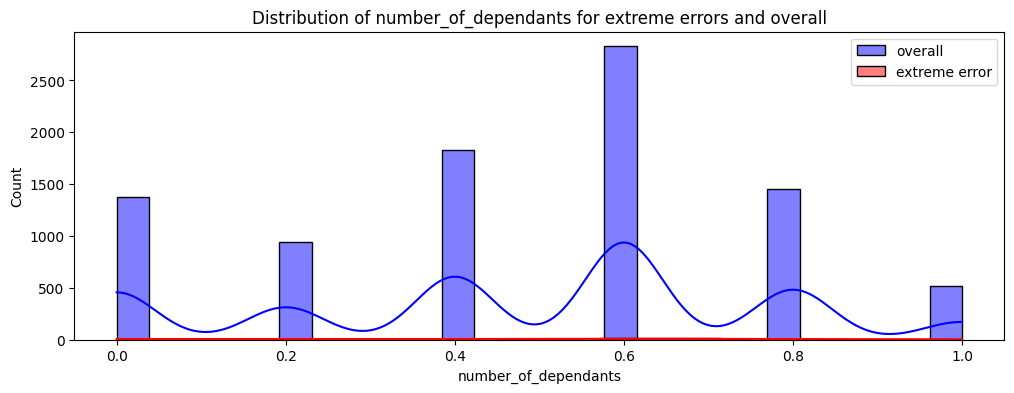

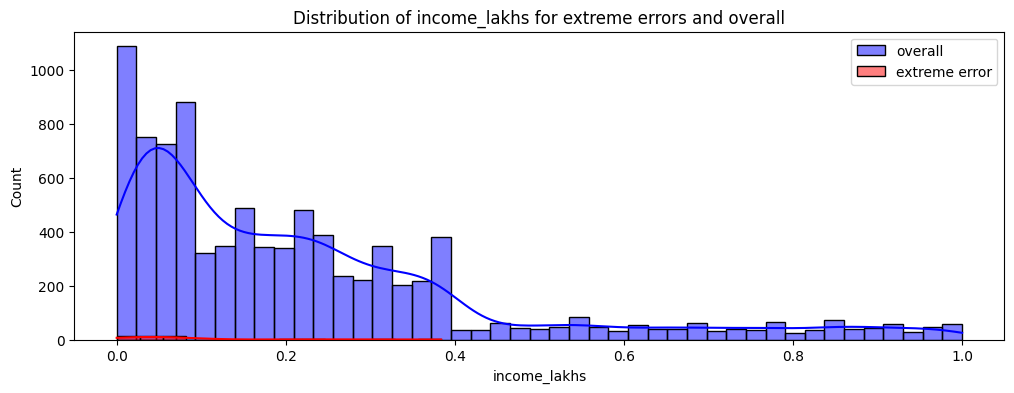

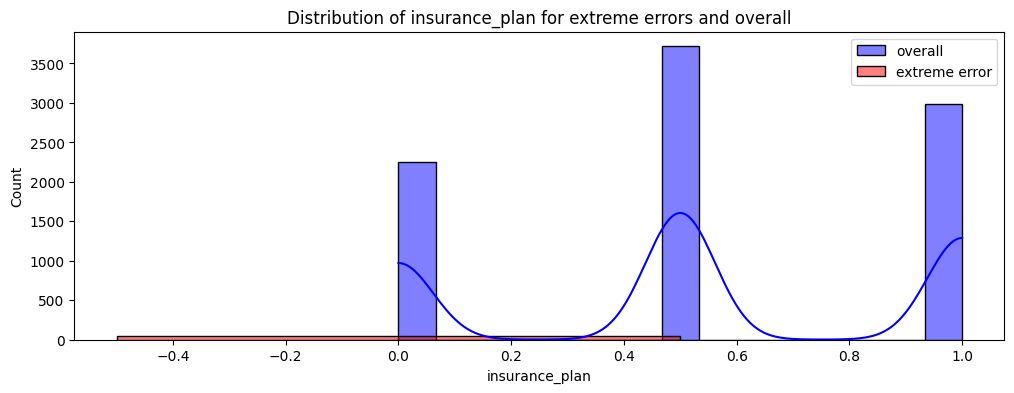

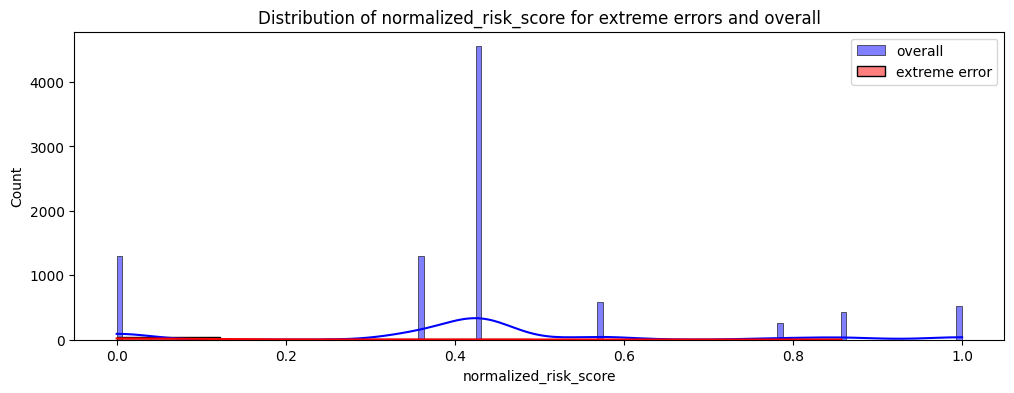

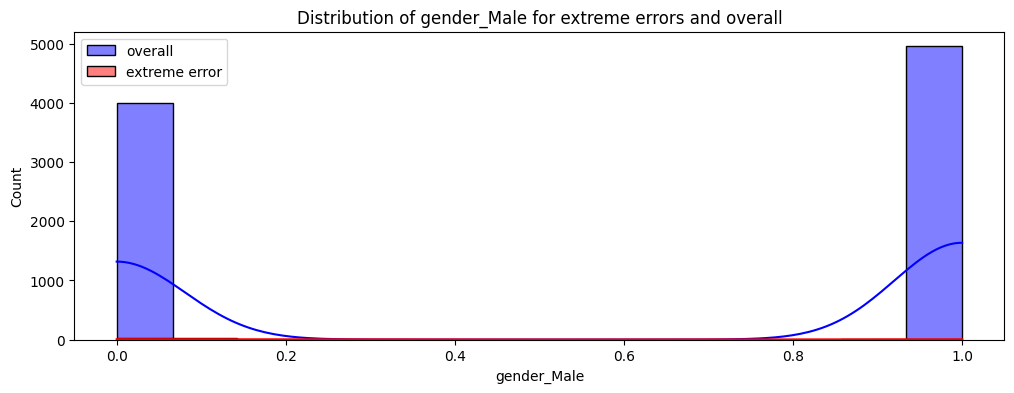

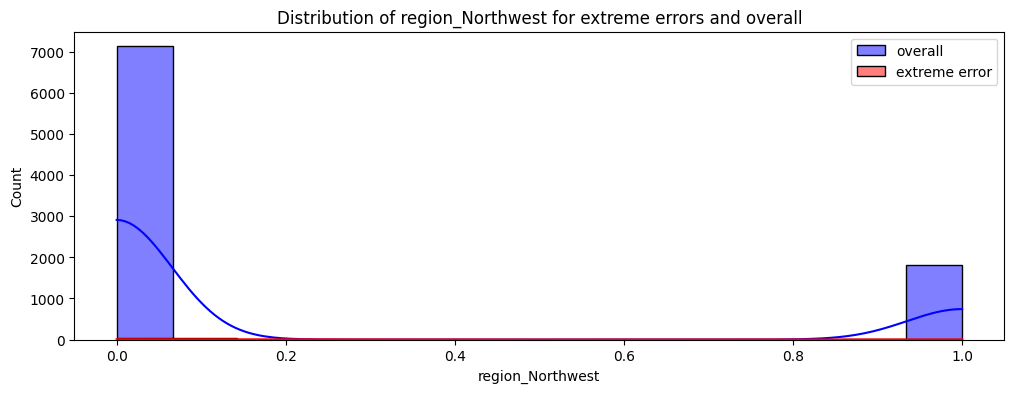

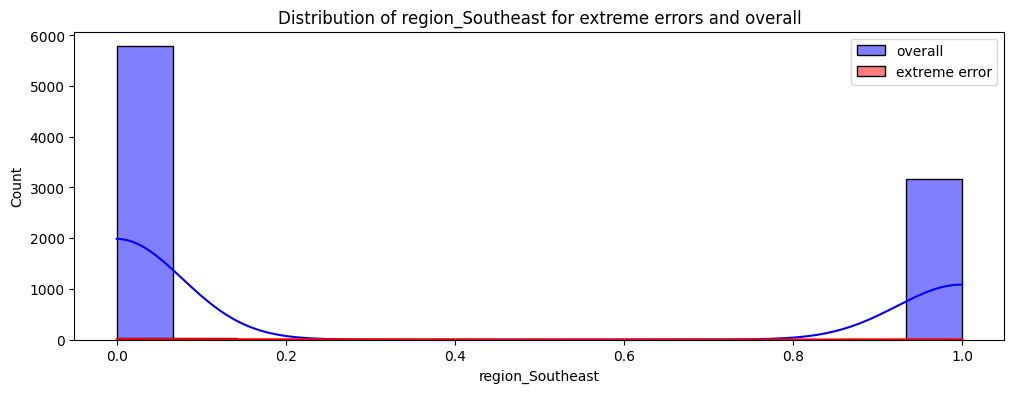

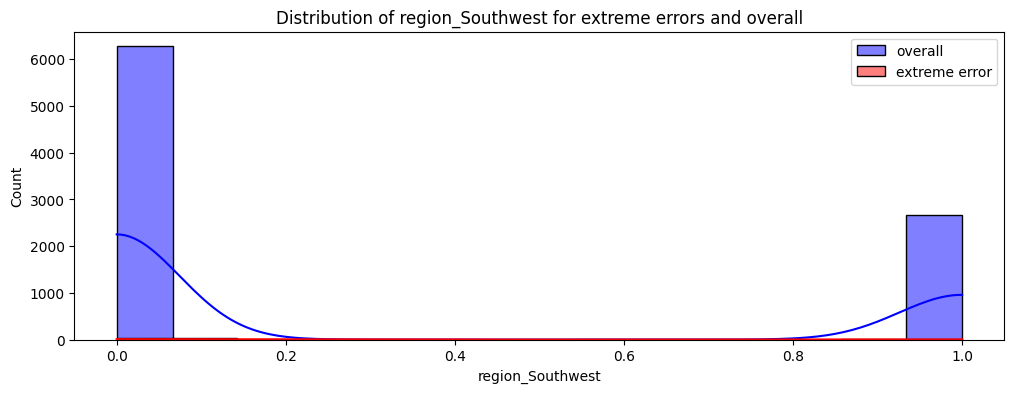

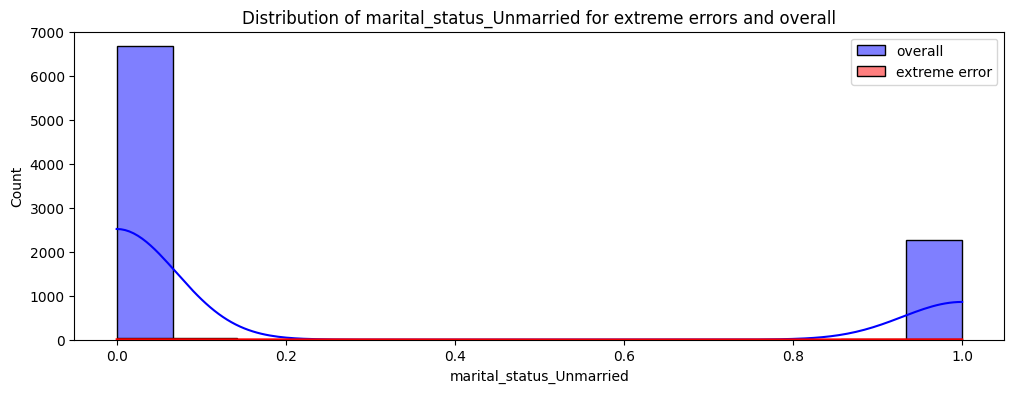

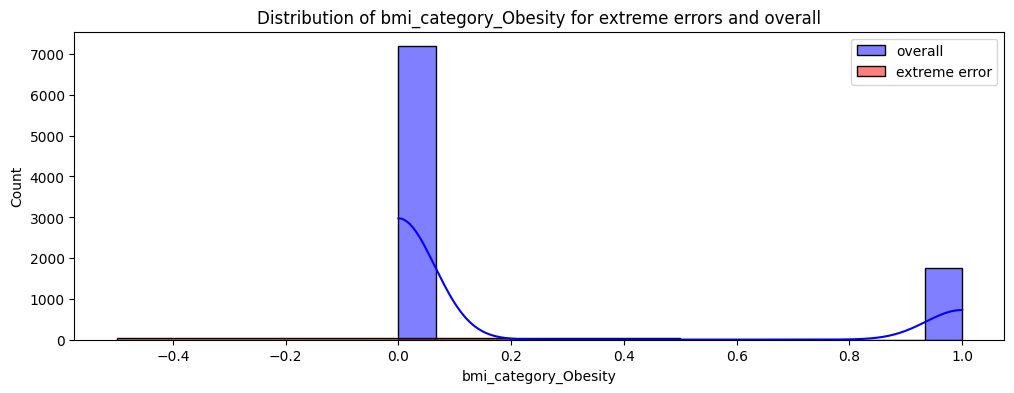

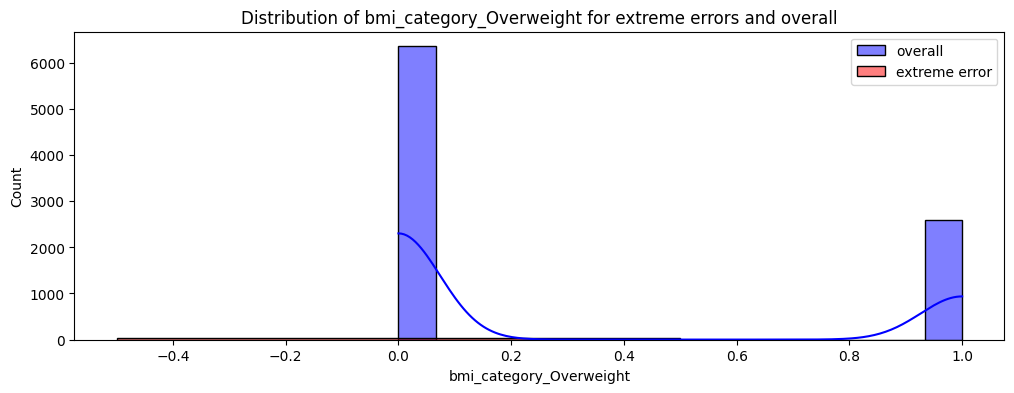

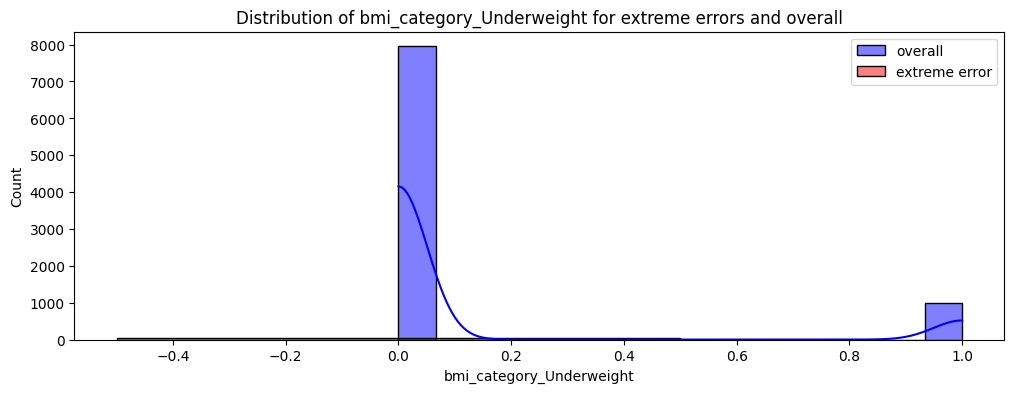

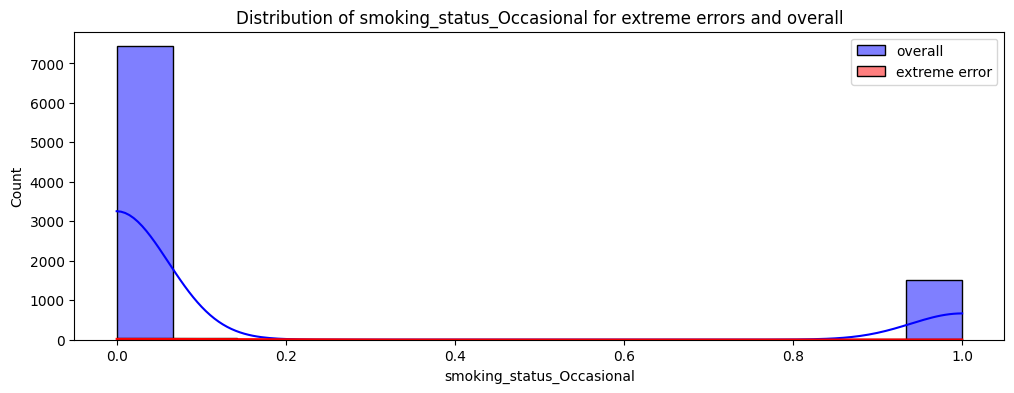

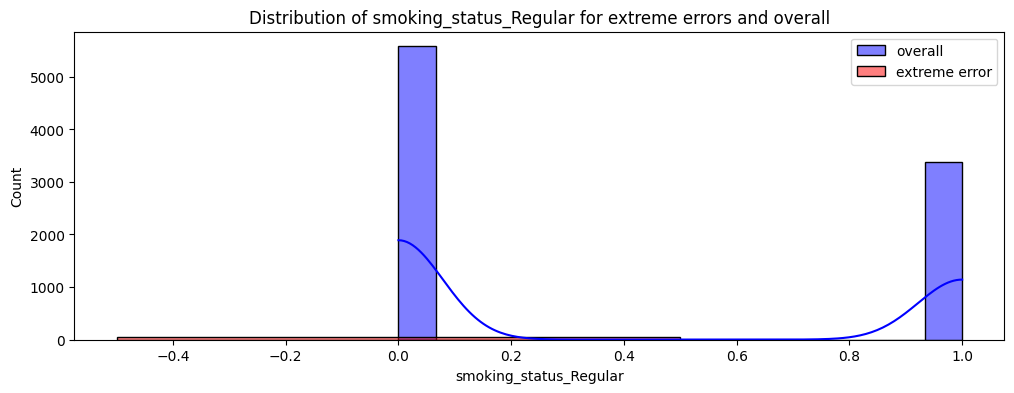

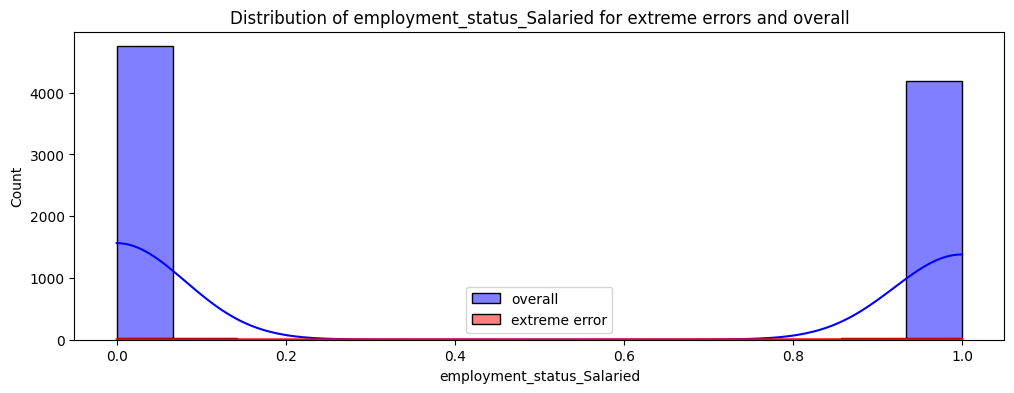

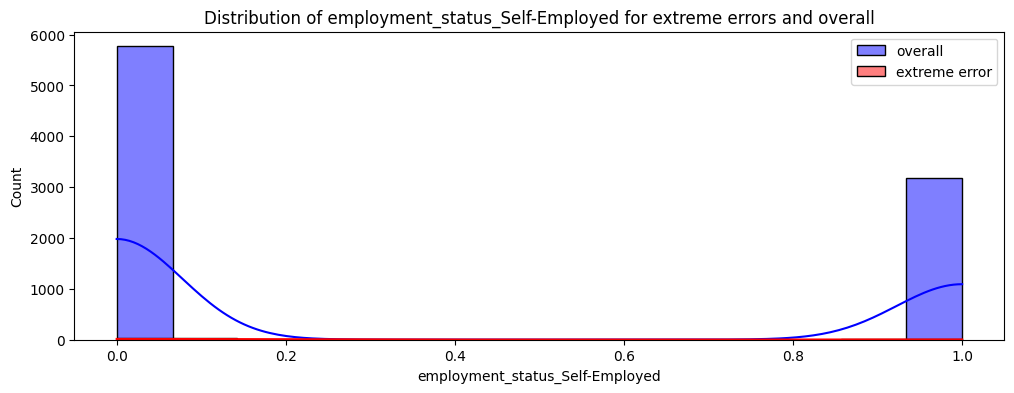

In [464]:
for columns in extreme_errors.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(X_test[columns], label='overall', kde=True, color='blue')
    sns.histplot(extreme_errors[columns],label='extreme error', kde=True, color='red',alpha=0.5)
    plt.legend()
    plt.title(f'Distribution of {columns} for extreme errors and overall')
    plt.show()

In [465]:
extreme_errors.sample(5)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14521,0.108696,0.0,0.060606,0.0,0.000000,0,0,1,0,1,0,0,0,0,0,0,0
28595,0.217391,0.0,0.303030,0.0,0.000000,0,0,0,1,1,0,0,0,1,0,0,1
26591,0.739130,0.6,0.212121,0.0,0.000000,1,0,1,0,0,0,0,0,0,0,0,1
508,0.326087,0.2,0.050505,0.0,0.428571,0,1,0,0,1,0,0,0,0,0,1,0
7508,0.260870,0.4,0.040404,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,1,0


##  Reverse scaling

In [466]:
col_to_scale=cols
col_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [467]:
extreme_errors['income_level']=-1

In [468]:
extreme_errors=scaler.inverse_transform(extreme_errors[col_to_scale])
extreme_result_df=pd.DataFrame(extreme_errors, columns=col_to_scale)
extreme_result_df.sample(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
3,57.0,3.0,-2.0,39.0,1.0
1,29.0,3.0,-2.0,3.0,1.0
37,32.0,4.0,-2.0,9.0,1.0
13,35.0,3.0,-2.0,2.0,1.0
12,33.0,2.0,-2.0,2.0,1.0


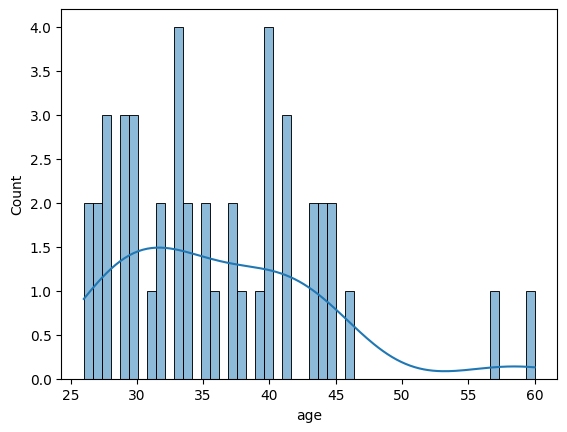

In [469]:
sns.histplot(extreme_result_df['age'], kde=True, bins=50)
plt.show()

In [470]:
print(f"25th percentile--->{extreme_result_df.age.quantile(0.25)}")
print(f"50th percentile--->{extreme_result_df.age.quantile(0.50)}")
print(f"75th percentile--->{extreme_result_df.age.quantile(0.75)}")
print(f"95th percentile--->{extreme_result_df.age.quantile(0.95)}")
print(f"97th percentile--->{extreme_result_df.age.quantile(0.97)}")
print(f"98th percentile--->{extreme_result_df.age.quantile(0.98)}")
print(f"99th percentile--->{extreme_result_df.age.quantile(0.99)}")
print(f"100th percentile--->{extreme_result_df.age.quantile(1)}")

25th percentile--->30.0
50th percentile--->35.0
75th percentile--->41.0
95th percentile--->45.8
97th percentile--->53.48
98th percentile--->57.35999999999999
99th percentile--->58.68000000000001
100th percentile--->60.0
